<a href="https://colab.research.google.com/github/shivendr7/ml/blob/GANs/DCGAN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(train_images, train_labels), (test_images, test_labels)=mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


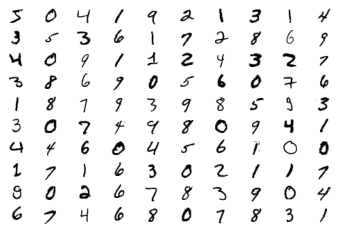

In [3]:
for i in range(100):
  plt.subplot(10,10,i+1)
  plt.axis('off')
  plt.imshow(train_images[i], cmap='gray_r')

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dense, Dropout, Flatten, Reshape

In [5]:
def build_discriminator():
  model=Sequential()
  model.add(Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', input_shape=(28,28,1)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  opt=Adam(learning_rate=0.002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [6]:
disc=build_discriminator()
disc.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [8]:
def build_generator(latent_dim):
  model=Sequential()
  model.add(Dense(128*7*7, input_shape=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape(target_shape=(7,7,128)))
  model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, kernel_size=(7,7), activation='sigmoid', padding='same'))
  return model

In [10]:
gen=build_generator((100,))
gen.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 28, 28, 128)      

In [11]:
def build_gan():
  model=Sequential()
  model.add(gen)
  model.add(disc)
  opt=Adam(learning_rate=0.002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [12]:
disc.trainable=False
gan=build_gan()
gan.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


In [13]:
X=np.expand_dims(train_images, axis=-1)
X=X.astype('float32')
X=X/255.0

In [14]:
def generate_real_samples(n_samples):
  ix=np.random.randint(0, X.shape[0], n_samples)
  x=X[ix]
  y=np.ones(shape=(n_samples,1))
  return x,y

In [16]:
xt,yt=generate_real_samples(10)
xt.shape, yt.shape

((10, 28, 28, 1), (10, 1))

In [17]:
def generate_latent_points(n_samples):
  p=np.random.randn(100*n_samples)
  return p.reshape(n_samples,100)
def generate_fake_samples(n_samples):
  x=generate_latent_points(n_samples)
  x=gen.predict(x)
  y=np.zeros(shape=(n_samples,1))
  return x,y

In [18]:
xt,yt=generate_fake_samples(10)
xt.shape, yt.shape

((10, 28, 28, 1), (10, 1))

In [23]:
def train(n_epochs=100, n_batch=256):
  bpe=X.shape[0]//n_batch
  half_batch=n_batch//2
  for i in range(n_epochs):
    for j in range(bpe):
      x_real, y_real=generate_real_samples(half_batch)
      x_fake, y_fake=generate_fake_samples(half_batch)
      dloss1,_ = disc.train_on_batch(x=x_real, y=y_real)
      dloss2,_ = disc.train_on_batch(x=x_fake, y=y_fake)
      gan_x=generate_latent_points(n_batch)
      gan_y=np.ones(shape=(n_batch, 1))
      gan_loss,_ = gan.train_on_batch(x=gan_x, y=gan_y)
      print('>%d>%d dloss1[%.3f] dloss2[%.3f] gloss[%.3f]'%(i+1,j+1,dloss1,dloss2,gan_loss))

In [24]:
train(5)

>1>1 dloss1[0.746] dloss2[0.285] gloss[1.934]
>1>2 dloss1[0.692] dloss2[0.381] gloss[1.387]
>1>3 dloss1[0.536] dloss2[0.717] gloss[0.713]
>1>4 dloss1[0.316] dloss2[0.718] gloss[0.695]
>1>5 dloss1[0.147] dloss2[0.693] gloss[0.714]
>1>6 dloss1[0.063] dloss2[0.669] gloss[0.742]
>1>7 dloss1[0.029] dloss2[0.639] gloss[0.788]
>1>8 dloss1[0.027] dloss2[0.591] gloss[0.883]
>1>9 dloss1[0.019] dloss2[0.506] gloss[1.086]
>1>10 dloss1[0.026] dloss2[0.372] gloss[1.507]
>1>11 dloss1[0.039] dloss2[0.215] gloss[2.167]
>1>12 dloss1[0.048] dloss2[0.112] gloss[2.764]
>1>13 dloss1[0.027] dloss2[0.061] gloss[3.283]
>1>14 dloss1[0.022] dloss2[0.038] gloss[3.674]
>1>15 dloss1[0.008] dloss2[0.024] gloss[4.047]
>1>16 dloss1[0.005] dloss2[0.016] gloss[4.394]
>1>17 dloss1[0.006] dloss2[0.012] gloss[4.595]
>1>18 dloss1[0.007] dloss2[0.010] gloss[4.694]
>1>19 dloss1[0.014] dloss2[0.010] gloss[4.685]
>1>20 dloss1[0.004] dloss2[0.010] gloss[4.802]
>1>21 dloss1[0.000] dloss2[0.008] gloss[5.059]
>1>22 dloss1[0.004] dl

KeyboardInterrupt: ignored

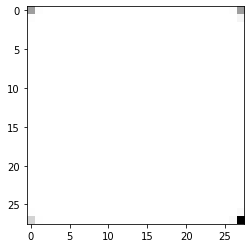

In [31]:
im=gen.predict(np.random.randn(100).reshape(1,100))
plt.imshow(im.reshape(28,28), cmap='gray_r')